In [2]:
# Importing necessary libraries for the analysis.
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

#import csv
#import pandas as pd


In [3]:
# Defining the constants and configurations used throughout the notebook.
iterations = 2101000 # 101000
on_remote = False
data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_SUBS_{iterations}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_SUBS_{iterations}.npy')
autoencoder_model = 'twice-4ds-8f'
autoencoder_path = Path(f'/nobackup/smhid20/users/sm_maran/results/{autoencoder_model}/') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/results/{autoencoder_model}/')
k = 150
spinup = 1001
spacing = 10
p_train = 0.8
mean_data = 0.003394413273781538
std_data = 9.174626350402832

# Data Loading

In [4]:
class QGSamplesDataset(Dataset):
    def __init__(self, data_path, mode, p_train, k, spinup, spacing, iterations, mean_data, std_data, device, transform=None):
        """
        Custom Dataset for loading QG samples lazily.

        Parameters:
        - data_path (str): Path to the dataset files.
        - mode (str): Mode of the dataset to be loaded ('train', 'val', 'test').
        - p_train (float): Percentage of data to be used for training.
        - k, spinup, spacing, iterations: Parameters for data generation.
        - transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_path = data_path
        self.data_dtype = 'float32'
        self.device = device

        self.mode = mode

        self.p_train = p_train
        self.k = k
        self.spinup = spinup
        self.spacing = spacing
        self.iterations = iterations
        self.mean_data = mean_data
        self.std_data = std_data

        self.transform = transform

        self.total_rows, self.total_columns = self._calculate_dimensions()
        self.X_indices, self.Y_indices = self._generate_indices()

        self.mmap = self.create_mmap()

    
    def create_mmap(self):
        return np.memmap(self.data_path, dtype=self.data_dtype, mode='r', shape=(self.total_rows, self.total_columns))


    def _calculate_dimensions(self):
        total_rows = self.iterations + 1
        total_columns = 4225 
        return total_rows, total_columns


    def _generate_indices(self):
        n_train = int(np.round(self.p_train * (self.total_rows - self.spinup)))  # Number of training samples
        n_val = int(np.round((1 - self.p_train) / 2 * (self.total_rows - self.spinup)))  # Number of validation samples
        # Assuming the remaining samples are used for testing

        if self.mode == 'train':
            start, stop = self.spinup, self.spinup + n_train
        elif self.mode == 'val':
            start, stop = self.spinup + n_train, self.spinup + n_train + n_val
        elif self.mode == 'test':
            start, stop = self.spinup + n_train + n_val, self.total_rows

        fit_x, fit_y = slice(start, stop - self.k), slice(start + self.k, stop)

        # Adjust indices for spacing if necessary
        X_indices = np.arange(fit_x.start, fit_x.stop)[::self.spacing]
        Y_indices = np.arange(fit_y.start, fit_y.stop)[::self.spacing]

        return X_indices, Y_indices


    def __len__(self):
        # Return the length of the dataset
        return self.X_indices.shape[0]

    def __getitem__(self, idx):
        # Calculate the actual data indices for X and Y based on the provided dataset index
        x_index = self.X_indices[idx]
        y_index = self.Y_indices[idx]

        # Access the specific samples directly from the memory-mapped array
        # This operation does not load the entire dataset into memory
        X_sample = self.mmap[x_index, :].astype(self.data_dtype)
        Y_sample = self.mmap[y_index, :].astype(self.data_dtype)

        # Normalize the samples if needed
        X_sample = (X_sample - self.mean_data) / self.std_data
        Y_sample = (Y_sample - self.mean_data) / self.std_data

        # Convert to tensors before returning
        X_sample = torch.tensor(X_sample, dtype=torch.float32).to(self.device)
        Y_sample = torch.tensor(Y_sample, dtype=torch.float32).to(self.device)

        return X_sample, Y_sample

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = QGSamplesDataset(data_path, 'train', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
val_dataset = QGSamplesDataset(data_path, 'val', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
test_dataset = QGSamplesDataset(data_path, 'test', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Autoencoder

In [5]:
class ConvolutionalAutoencoder4(nn.Module):
    """
    Convolutional Autoencoder for encoding and decoding images.
    """
    def __init__(self, filters, latent_dim=100, no_downsamples=2, activation=nn.ReLU(True)):
        """
        Initializes the model with the specified configuration.
        
        Parameters:
        - filters (int): Number of filters in the first convolutional layer.
        - latent_dim (int): Dimensionality of the latent space.
        - no_downsamples (int): Number of downsampling steps in the encoder.
        """
        super(ConvolutionalAutoencoder4, self).__init__()
        self.image_size = 65
        self.filters = filters
        self.no_downsamples = no_downsamples
        self.latent_dim = latent_dim
        self.activation = activation             #nn.LeakyReLU(0.2, inplace=True)

        dim = self.filters

        encoder_layers = [
            nn.Unflatten(1, (1,self.image_size, self.image_size)),
            nn.Conv2d(in_channels=1, out_channels=self.filters, kernel_size=4, padding=1),
            self.activation,
        ]

        for _ in range(self.no_downsamples):
            encoder_layers.extend(self._block(dim, dim*2, kernel_size=3, stride=1))
            dim *= 2
            encoder_layers.extend(self._block(dim, dim, kernel_size=4, stride=2))

        enc_img_sz = self.image_size//2**self.no_downsamples
        
        encoder_layers.append(nn.Flatten(start_dim=1))
        encoder_layers.append(nn.Linear(in_features=dim * enc_img_sz * enc_img_sz, out_features=self.latent_dim))
        self.encoder = nn.Sequential(*encoder_layers)

        decoder_layers = [
            nn.Linear(in_features=self.latent_dim, out_features=dim * enc_img_sz * enc_img_sz),
            self.activation,
            nn.Unflatten(1, (dim, enc_img_sz, enc_img_sz)),
        ]
        
        for _ in range(self.no_downsamples):
            decoder_layers.extend(self._upblock(dim, dim//2, kernel_size=4, stride=2))
            dim //= 2
            decoder_layers.extend(self._block(dim, dim, kernel_size=3, stride=1))
            
        decoder_layers.append(nn.ConvTranspose2d(in_channels=self.filters, out_channels=1, kernel_size=4, padding=1))
        decoder_layers.append(nn.Flatten(start_dim=1))
        self.decoder = nn.Sequential(*decoder_layers)
        
        self.apply(self.init_weights)

    def _block(self, in_channels, out_channels, kernel_size, stride):
        return [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            self.activation,
        ]
    
    def _upblock(self, in_channels, out_channels, kernel_size, stride):
        return [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            self.activation,
        ]
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 1.0, 0.02)
            torch.nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = self.encoder(x)
        activations = x  # Store the activations from the encoder
        x = self.decoder(x)
        return x, activations


In [6]:
import json
# FILEPATH: /c:/Users/svart/Desktop/MEX/QG-Forecasting/Diffusion.ipynb
# Load the saved model
saved_model = torch.load(autoencoder_path / 'best_model.pth')

# Read parameters from JSON file
with open(autoencoder_path / 'config.json', 'r') as json_file:
    parameters = json.load(json_file)

# Extract the desired parameters
filters = parameters['filters']
latent_dim = parameters['latent_dim']
no_downsamples = parameters['no_downsamples']

# Create an instance of the ConvolutionalAutoencoder class
autoencoder = ConvolutionalAutoencoder4(filters=filters, latent_dim=latent_dim, no_downsamples=no_downsamples)

# Load the state_dict of the saved model into the conv_autoencoder
autoencoder.load_state_dict(saved_model)

autoencoder.to(device)

ConvolutionalAutoencoder4(
  (activation): ReLU(inplace=True)
  (encoder): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(1, 65, 65))
    (1): Conv2d(1, 8, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReL

# Diffusion

We need 
- Step 1: Forward Process - Noise Scheduler
- Step 2: Backward Process - Neural Network (U-net)
- Timestep Encoding

Step 3: Loss


### Step 1: Forward Process

$q(x_t|x_{t-1}) = N(x_t; \sqrt{1-\beta_t} x_{t-1}, \beta_t I)$

$q(x_t|x_0) = N(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) I)$

We add noise linearly. 
alpha = 1 - beta
alphahat is product of alpha

In [7]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end = 0.02):
    return torch.linspace(start, end, timesteps)

def forward_diffusion_sample(x_0, t, device):
    noise = torch.randn_like(x_0)
    img = sqrt_one_minus_alphas_bar[t].to(device) * noise.to(device) \
            + sqrt_alphas_bar[t].to(device) * x_0
    return img

T = 1000
betas = linear_beta_schedule(T)

alphas = 1. - betas
alphas_bar = torch.cumprod(alphas, 0)
sqrt_alphas_bar = torch.sqrt(alphas_bar)
sqrt_one_minus_alphas_bar = torch.sqrt(1. - alphas_bar)

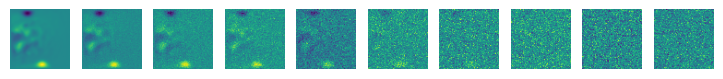

In [8]:
test_image = next(iter(train_loader))[0][0]

plt.figure(figsize=(10, 10))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for i in range(num_images):
    t = torch.Tensor([i*stepsize]).type(torch.int32)
    img = forward_diffusion_sample(test_image, t, device)
    plt.subplot(1, num_images+1, i+1)
    plt.imshow(img.cpu().detach().numpy().reshape((65,65)))
    plt.axis('off')

### Step 2: Backward Process

In [44]:
class Autoencoder(nn.Module):
    """
    Convolutional Autoencoder for encoding and decoding images.
    """
    def __init__(self, filters, no_latent_channels=2, no_downsamples=3, activation=nn.ReLU(True)):
        """
        Initializes the model with the specified configuration.
        
        Parameters:
        - filters (int): Number of filters in the first convolutional layer.
        - latent_dim (int): Dimensionality of the latent space.
        - no_downsamples (int): Number of downsampling steps in the encoder.
        """
        super(Autoencoder, self).__init__()
        self.image_size = 65
        self.input_channels = 1
        self.filters = filters
        self.no_downsamples = no_downsamples
        self.no_latent_channels = no_latent_channels
        self.activation = activation             #nn.LeakyReLU(0.2, inplace=True)

        dim = self.filters

        # Encoder
        self.downs = nn.ModuleList()
        encoder_layers = [
            nn.Unflatten(1, (1,self.image_size, self.image_size)),
        ]

        for i in range(self.no_downsamples+1):
            if i == 0:
                encoder_layers.extend(self._block(self.input_channels, dim, kernel_size=4, stride=1, batchnorm=False))
            else:
                encoder_layers.extend(self._block(dim, dim*2, kernel_size=3, stride=1))
                dim *= 2
            
            encoder_layers.extend(self._block(dim, dim, kernel_size=3, stride=1))
            
            if i == self.no_downsamples:
                encoder_layers.append(nn.Conv2d(in_channels=dim, out_channels=self.no_latent_channels, kernel_size=3, padding=1))

            else:
                encoder_layers.extend(self._block(dim, dim, kernel_size=4, stride=2))
            
            self.downs.append(nn.Sequential(*encoder_layers))
            encoder_layers = []

        # Decoder
        self.ups = nn.ModuleList()
        decoder_layers = []
        
        for i in range(self.no_downsamples + 1):
            if i == 0:
                decoder_layers.extend(self._block(self.no_latent_channels, dim, kernel_size=3, stride=1))
            else:
                decoder_layers.extend(self._upblock(dim, dim, kernel_size=4, stride=2))
            
            decoder_layers.extend(self._block(dim, dim, kernel_size=3, stride=1))
            
            if i == self.no_downsamples:
                decoder_layers.append(nn.ConvTranspose2d(in_channels=dim, out_channels=self.input_channels, kernel_size=4, padding=1))
                decoder_layers.append(nn.Flatten(start_dim=1))

            else:
                decoder_layers.extend(self._block(dim, dim//2, kernel_size=3, stride=1))
                dim //= 2
            
            self.ups.append(nn.Sequential(*decoder_layers))
            decoder_layers = []
            
        # Initialize weights
        self.apply(self.init_weights)

    def _block(self, in_channels, out_channels, kernel_size, stride, batchnorm=True):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),]
        if batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(self.activation)
        return layers
        
    def _upblock(self, in_channels, out_channels, kernel_size, stride):
        return [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            self.activation,
        ]
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 1.0, 0.02)
            torch.nn.init.constant_(m.bias, 0.0)

    def encoder(self, x):
        for down in self.downs:
            x = down(x)
        return x
    
    def decoder(self, x):
        for up in self.ups:
            x = up(x)
        return x
    
    def forward(self, x):
        x = self.encoder(x)
        activations = x
        x = self.decoder(x)
        return x, activations


In [49]:
model = Autoencoder(filters=16, no_latent_channels=1, no_downsamples=4)  # Example sizes
model.to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total number of parameters in the model: {total_params}")
print(model.state_dict)

for data, _ in train_loader:
    img = data
    output, activation = model(img)
    break

Total number of parameters in the model: 3063490
<bound method Module.state_dict of UNet(
  (activation): ReLU(inplace=True)
  (downs): ModuleList(
    (0): Sequential(
      (0): Unflatten(dim=1, unflattened_size=(1, 65, 65))
      (1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), 

In [93]:
class Autoencoder(nn.Module):
    """
    Convolutional Autoencoder for encoding and decoding images.
    """
    def __init__(self, filters, no_latent_channels=2, no_downsamples=3, activation=nn.ReLU(True)):
        """
        Initializes the model with the specified configuration.
        
        Parameters:
        - filters (int): Number of filters in the first convolutional layer.
        - latent_dim (int): Dimensionality of the latent space.
        - no_downsamples (int): Number of downsampling steps in the encoder.
        """
        super(Autoencoder, self).__init__()
        self.image_size = 65
        self.input_channels = 1
        self.filters = filters
        self.no_downsamples = no_downsamples
        self.no_latent_channels = no_latent_channels
        self.activation = activation             #nn.LeakyReLU(0.2, inplace=True)

        dim = self.filters

        # Encoder
        self.downs = nn.ModuleList()
        encoder_layers = [
            nn.Unflatten(1, (1,self.image_size, self.image_size)),
        ]

        for i in range(self.no_downsamples+1):
            if i == 0:
                encoder_layers.extend(self._block(self.input_channels, dim, kernel_size=4, stride=1, batchnorm=False))
            
            else:
                encoder_layers.extend(self._block(dim, dim, kernel_size=4, stride=2))
                encoder_layers.extend(self._block(dim, dim*2, kernel_size=3, stride=1))
                dim *= 2
            
            if i == self.no_downsamples:
                encoder_layers.append(nn.Conv2d(dim, self.no_latent_channels, kernel_size=3, padding=1))
            else:
                encoder_layers.extend(self._block(dim, dim, kernel_size=3, stride=1))
            
            self.downs.append(nn.Sequential(*encoder_layers))
            encoder_layers = []
        
        # Decoder
        self.ups = nn.ModuleList()
        decoder_layers = []
        
        for i in range(self.no_downsamples + 1):
            if i == 0:
                decoder_layers.extend(self._block(self.no_latent_channels, dim, kernel_size=3, stride=1))
            else:
                decoder_layers.extend(self._block(dim, dim, kernel_size=3, stride=1)) # Unet change
            
            
            
            if i == self.no_downsamples:
                decoder_layers.append(nn.ConvTranspose2d(in_channels=dim, out_channels=self.input_channels, kernel_size=4, padding=1))
                decoder_layers.append(nn.Flatten(start_dim=1))

            else:
                decoder_layers.extend(self._block(dim, dim//2, kernel_size=3, stride=1))
                dim //= 2
                decoder_layers.extend(self._upblock(dim, dim, kernel_size=4, stride=2))

            self.ups.append(nn.Sequential(*decoder_layers))
            decoder_layers = []
            
        # Initialize weights
        self.apply(self.init_weights)

    def _block(self, in_channels, out_channels, kernel_size, stride, batchnorm=True):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),]
        if batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(self.activation)
        return layers
        
    def _upblock(self, in_channels, out_channels, kernel_size, stride):
        return [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            self.activation,
        ]
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 1.0, 0.02)
            torch.nn.init.constant_(m.bias, 0.0)

    def encoder(self, x):
        for down in self.downs:
            x = down(x)
        return x
    
    def decoder(self, x):
        for up in self.ups:
            x = up(x)
        return x
    
    def forward(self, x):
        x = self.encoder(x)
        activations = x
        print(x.shape)
        x = self.decoder(x)
        return x, activations


In [99]:
model = Autoencoder(filters=16, no_latent_channels=1, no_downsamples=3)  # Example sizes
model.to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total number of parameters in the model: {total_params}")
print(model.state_dict)

for data, _ in train_loader:
    img = data
    output, activation = model(img)
    break

Total number of parameters in the model: 467906
<bound method Module.state_dict of Autoencoder(
  (activation): ReLU(inplace=True)
  (downs): ModuleList(
    (0): Sequential(
      (0): Unflatten(dim=1, unflattened_size=(1, 65, 65))
      (1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 32, kernel_size=(3

In [14]:
class UNet(nn.Module):
    """
    Convolutional Autoencoder for encoding and decoding images.
    """
    def __init__(self, filters, no_latent_channels=2, no_downsamples=3, image_size = 65, input_channels = 1, isUNet = False, activation=nn.ReLU(True)):
        """
        Initializes the model with the specified configuration.
        
        Parameters:
        - filters (int): Number of filters in the first convolutional layer.
        - no_latent_channels (int): Number of channels in the latent space.
        - no_downsamples (int): Number of downsampling steps in the encoder.
        - activation (nn.Module): Activation function to use in the model.
        """
        super(UNet, self).__init__()
        self.image_size = image_size
        self.input_channels = input_channels
        self.filters = filters
        self.no_downsamples = no_downsamples
        self.no_latent_channels = no_latent_channels
        self.activation = activation

        self.isUNet = isUNet
        scale = 2 if self.isUNet else 1
        kernel_size = 3 if self.isUNet else 4

        dim = self.filters

        # Encoder
        self.downs = nn.ModuleList()
        encoder_layers = []
        if not self.isUNet:
            encoder_layers.append(nn.Unflatten(1, (1,self.image_size, self.image_size)))

        # Construct the encoder layers
        for i in range(self.no_downsamples+1):
            if i == 0:
                encoder_layers.extend(self._block(self.input_channels, dim, kernel_size=kernel_size, stride=1, batchnorm=False))
            else:
                encoder_layers.extend(self._block(dim, dim, kernel_size=4, stride=2))
                encoder_layers.extend(self._block(dim, dim*2, kernel_size=3, stride=1))
                dim *= 2

            if i == self.no_downsamples:
                if not self.isUNet:
                    encoder_layers.append(nn.Conv2d(dim, self.no_latent_channels, kernel_size=3, padding=1))
            else:
                encoder_layers.extend(self._block(dim, dim, kernel_size=3, stride=1))

            self.downs.append(nn.Sequential(*encoder_layers))
            encoder_layers = []
        
        # Decoder
        self.ups = nn.ModuleList()
        decoder_layers = []

        # Construct the decoder layers
        for i in range(self.no_downsamples + 1):
            if i == 0:
                if not self.isUNet:
                    decoder_layers.extend(self._block(self.no_latent_channels, dim, kernel_size=3, stride=1))
            else:
                decoder_layers.extend(self._block(dim*scale, dim, kernel_size=3, stride=1)) # Change for UNet
            
            if i == self.no_downsamples:
                decoder_layers.append(nn.ConvTranspose2d(in_channels=dim, out_channels=self.input_channels, kernel_size=kernel_size, padding=1))
                if not self.isUNet:
                    decoder_layers.append(nn.Flatten(start_dim=1))
            else:
                decoder_layers.extend(self._block(dim, dim//2, kernel_size=3, stride=1))
                dim //= 2
                decoder_layers.extend(self._upblock(dim, dim, kernel_size=4, stride=2))

            self.ups.append(nn.Sequential(*decoder_layers))
            decoder_layers = []
            
        # Initialize weights
        self.apply(self.init_weights)

    def _block(self, in_channels, out_channels, kernel_size, stride, batchnorm=True):
        """
        Helper function to create a convolutional block with optional batch normalization and activation.
        """
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),]
        if batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(self.activation)
        return layers
        
    def _upblock(self, in_channels, out_channels, kernel_size, stride):
        """
        Helper function to create a transposed convolutional block with batch normalization and activation.
        """
        return [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            self.activation,
        ]
    
    @staticmethod
    def init_weights(m):
        """
        Initialize weights of the model.
        """
        if isinstance(m, (nn.Conv2d, nn.Linear, nn.ConvTranspose2d)):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 1.0, 0.02)
            torch.nn.init.constant_(m.bias, 0.0)
    
    def encoder(self, x):
        for down in self.downs:
            x = down(x)
        return x
    
    def decoder(self, x):
        for up in self.ups:
            x = up(x)
        return x
    
    def forward(self, x):
        """
        Forward pass through the U-Net.
        """
        if self.isUNet:
            down_outputs = []

            for down in self.downs:
                x = down(x)
                down_outputs.append(x)

            activations = x

            for i, up in enumerate(self.ups):
                down_output = down_outputs.pop()
                if i > 0:
                    x = torch.cat([x, down_output], dim=1)
                x = up(x)
        else:
            x = self.encoder(x)
            activations = x
            x = self.decoder(x)
            
        return x, activations

In [9]:
model = UNet(filters=16, no_latent_channels=1, no_downsamples=3, isUNet=False)  # Example sizes
model.to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total number of parameters in the model: {total_params}")
print(model.state_dict)

for data, _ in train_loader:
    img = data
    output = model(img.reshape((-1 ,1, 65,65)))
    break

Total number of parameters in the model: 467906
<bound method Module.state_dict of UNet(
  (activation): ReLU(inplace=True)
  (downs): ModuleList(
    (0): Sequential(
      (0): Unflatten(dim=1, unflattened_size=(1, 65, 65))
      (1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 32, kernel_size=(3, 3), s

RuntimeError: unflatten: Provided sizes [1, 65, 65] don't multiply up to the size of dim 1 (1) in the input tensor

In [18]:
autoencoder = UNet(filters=16, no_latent_channels=1, no_downsamples=2, isUNet=False)  # Example sizes
autoencoder.to(device)

unet = UNet(filters=16, no_downsamples=2, isUNet=True)  # Example sizes
unet.to(device)

for data, _ in train_loader:
    img = data
    print(img.shape)
    _, latent = autoencoder(img)
    print(latent.shape)

    output,_ = unet(latent)
    break

print(output.shape)

total_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)

print(f"Total number of parameters in autoencoder: {total_params}")

total_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)

print(f"Total number of parameters in the UNet: {total_params}")

print(autoencoder.state_dict)

print(unet.state_dict)

torch.Size([64, 4225])
torch.Size([64, 1, 16, 16])
torch.Size([64, 1, 16, 16])
Total number of parameters in autoencoder: 112962
Total number of parameters in the UNet: 122913
<bound method Module.state_dict of UNet(
  (activation): ReLU(inplace=True)
  (downs): ModuleList(
    (0): Sequential(
      (0): Unflatten(dim=1, unflattened_size=(1, 65, 65))
      (1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, mo